In [10]:
# Cell 1 – Libraries and Setup
import pandas as pd
import numpy as np
import sys
import os
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import scienceplots

# Add the project root directory to Python path
sys.path.append('/Users/alexanderithakis/Documents/GitHub/D4PG-QR-FRM')

# Import project modules
from src.lsm_swing_pricer import price_swing_option_lsm
from src.swing_contract import SwingContract
from src.simulate_hhk_spot import simulate_hhk_spot, no_seasonal_function

---
# Longstaff-Schwartz Monte Carlo (LSM) for Swing Options

**Mathematical Framework**

The LSM method prices swing options by solving the optimal stopping problem through backward induction:

**Value Function Recursion**  
For a swing option with $R$ remaining exercise rights at time $t$:
$$V_t^{(r)} = \max\left\{ g_t + V_t^{(r-1)}, \mathbb{E}[e^{-r\Delta t} V_{t+\Delta t}^{(r)} | \mathcal{F}_t] \right\}$$

where:
- $g_t = q_{\max} \max(S_t - K, 0)$ is the immediate exercise payoff
- $V_t^{(r)}$ is the option value with $r$ rights remaining
- $\mathbb{E}[e^{-r\Delta t} V_{t+\Delta t}^{(r)} | \mathcal{F}_t]$ is the continuation value

**Polynomial Regression Approximation**  
Since the continuation value is unknown, LSM approximates it using polynomial regression:
$$\mathbb{E}[e^{-r\Delta t} V_{t+\Delta t}^{(r)} | \mathcal{F}_t] \approx \sum_{k=0}^{K} \beta_k S_t^k$$

**Backward Induction Algorithm**  
1. **Terminal condition**: $V_T^{(r)} = g_T$ for $r \geq 1$
2. **Regression step**: For each $t < T$ and $r$, regress discounted future values on polynomial basis of $S_t$
3. **Exercise decision**: Exercise if $g_t + \hat{V}_t^{(r-1)} > \hat{C}_t^{(r)}$ where $\hat{C}_t^{(r)}$ is the fitted continuation value
4. **Value update**: $V_t^{(r)} = \max\{g_t + \hat{V}_t^{(r-1)}, \hat{C}_t^{(r)}\}$

**Key Implementation Details**
- Regression performed only on in-the-money paths where $S_t > K$
- Rights are discrete: $R = \lfloor Q_{\max} / q_{\max} \rfloor$
- Each exercise consumes one right and generates payoff $q_{\max} \max(S_t - K, 0)$

In [11]:
# Monthly Swing Option Contract Parameters
swing_contract = SwingContract(
    q_min=0.0,                  # No minimum exercise requirement per day
    q_max=2.0,                  # Max 2 units per day (reasonable daily limit)
    Q_min=0.0,                  # No minimum total exercise requirement
    Q_max=20.0,                 # Max 20 units total over the month (10 days worth)
    strike=1.0,                 # At-the-money strike
    maturity=1/12,              # 1 month = 1/12 year
    n_rights=22,                # ~22 trading days in a month
    r=0.05,                     # 5% annual risk-free rate
    min_refraction_days=0       # No refraction period (can exercise daily)
)

# Market Process Parameters (HHK model - monthly calibration)
stochastic_process_params = {
    'S0': 1.0,                  # Initial spot price
    'T': swing_contract.maturity, # 1/12 year
    'n_steps': swing_contract.n_rights - 1,  # 21 steps (22 decision points)
    'n_paths': 8192,            # Evaluation paths for LSM
    'alpha': 12.0,              # Higher mean reversion for monthly timeframe
    'sigma': 1.2,               # Moderate volatility for monthly period
    'beta': 150.0,              # Jump decay rate
    'lam': 6.0,                 # Jump intensity (6 jumps per year average)
    'mu_J': 0.3,                # Mean jump size (30%)
    'f': no_seasonal_function   # No seasonal function
}
print("Derived Parameters:")
R = int(round(swing_contract.Q_max / swing_contract.q_max))
print(f"  Discrete exercise rights: {R}")
print(f"  Time step: {swing_contract.maturity / (swing_contract.n_rights - 1):.6f} years")
print(f"  Discount factor per step: {swing_contract.discount_factor:.6f}")

Derived Parameters:
  Discrete exercise rights: 10
  Time step: 0.003968 years
  Discount factor per step: 0.999802


In [4]:
# Generate Monte Carlo dataset
t, S, X, Y = simulate_hhk_spot(**stochastic_process_params, seed=42)
dataset = (t, S, X, Y)

print(f"Generated {S.shape[0]:,} paths with {S.shape[1]} time steps")
print(f"Time horizon: {t[-1]:.4f} years")
print(f"Dataset size: {S.nbytes / 1024**2:.1f} MB\n")

# Run LSM pricing with custom CSV name
csv_filename = "lsm_validation_analysis.csv"

mean_lsm_price, (ci_low, ci_high) = price_swing_option_lsm(
    contract=swing_contract,
    dataset=dataset,
    poly_degree=3,          # Cubic polynomials for regression
    n_bootstrap=1000,       # Bootstrap samples for confidence interval
    seed=123,
    csv_path=csv_filename,
    _print_results=True
)

print("LSM Pricing Results:")
print(f"  Option Price: {mean_lsm_price:.6f}")
print(f"  95% CI: [{ci_low:.6f}, {ci_high:.6f}]")
print(f"  CI Width: {ci_high - ci_low:.6f}")
print(f"  Relative CI Width: {(ci_high - ci_low) / mean_lsm_price * 100:.2f}%")

# Load the generated CSV for analysis
lsm_data = pd.read_csv(csv_filename)

Generated 8,192 paths with 22 time steps
Time horizon: 0.0833 years
Dataset size: 1.4 MB



Swing option price: 2.6648
95% CI: [2.6079, 2.7259]
LSM Pricing Results:
  Option Price: 2.664840
  95% CI: [2.607943, 2.725930]
  CI Width: 0.117987
  Relative CI Width: 4.43%


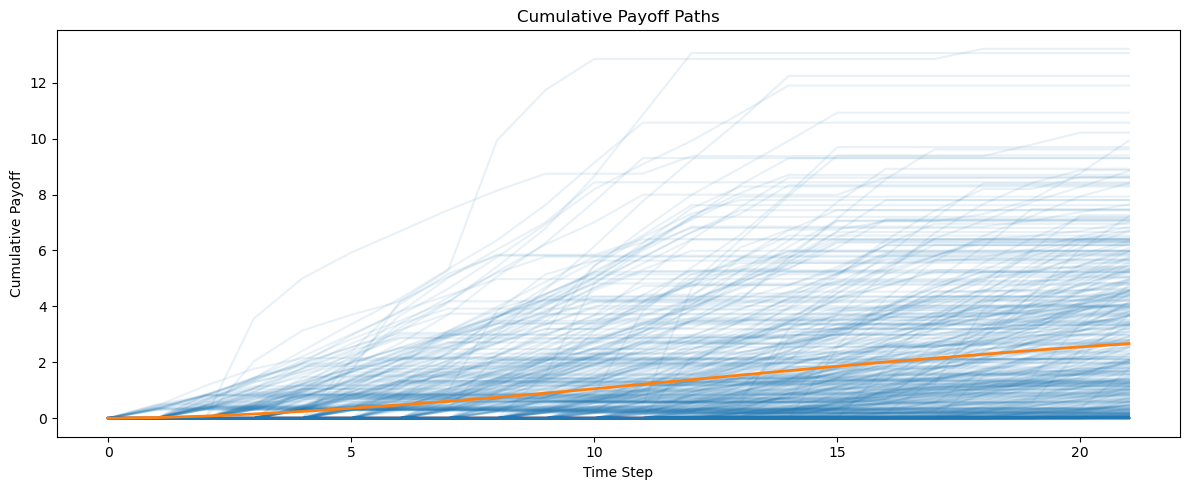

In [7]:
# make a new column where its the cumulative payoff per path up to that time step
lsm_data['cum_payoff'] = lsm_data.groupby('path')['payoff'].cumsum()

# I want a matrix where rows are paths and columns are cum_payoff
cum_payoff_matrix = lsm_data.pivot(index='path', columns='time_step', values='cum_payoff').values.T
cum_payoff_mean = cum_payoff_matrix.mean(axis=1)

plt.figure(figsize=(12, 5))
plt.plot(lsm_data['time_step'].unique(), cum_payoff_matrix[:,:500], alpha=0.1, color='tab:blue')
plt.plot(lsm_data['time_step'].unique(), cum_payoff_mean, color='tab:orange', linewidth=2, label='Mean Cumulative Payoff')
plt.title('Cumulative Payoff Paths')
plt.xlabel('Time Step')
plt.ylabel('Cumulative Payoff')
plt.tight_layout()
plt.show()

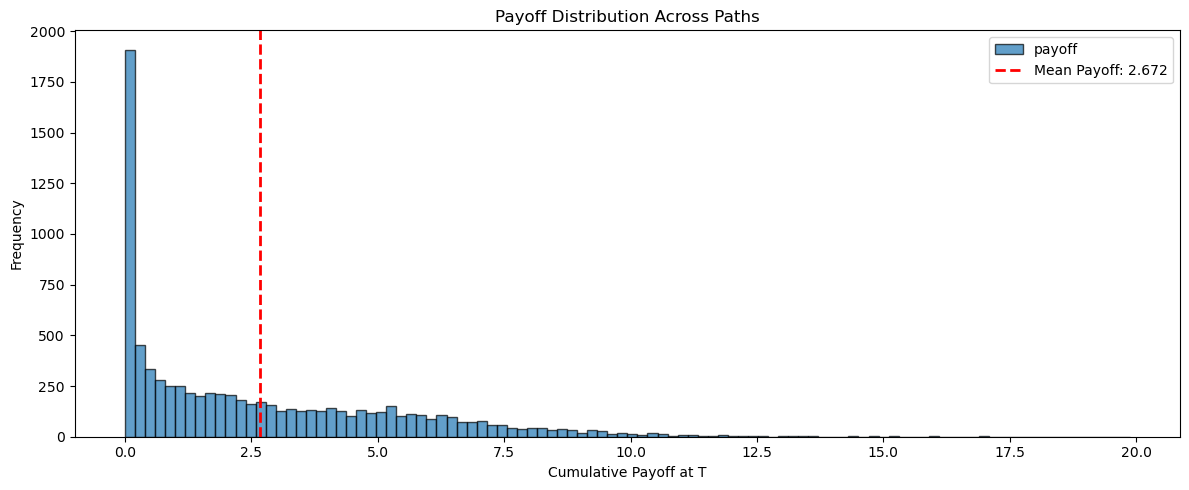

In [6]:
ax = lsm_data.groupby('path')['payoff'].agg('sum').plot(kind='hist', bins=100, edgecolor='black', alpha=0.7,
                                             title='Payoff Distribution Across Paths', figsize=(12, 5))
# add vertical line for mean payoff
mean_payoff = lsm_data.groupby('path')['payoff'].agg('sum').mean()
ax.axvline(mean_payoff, color='red', linestyle='--', linewidth=2, label=f'Mean Payoff: {mean_payoff:.3f}')
ax.set_xlabel('Cumulative Payoff at T')
ax.legend()
plt.tight_layout()
plt.show()

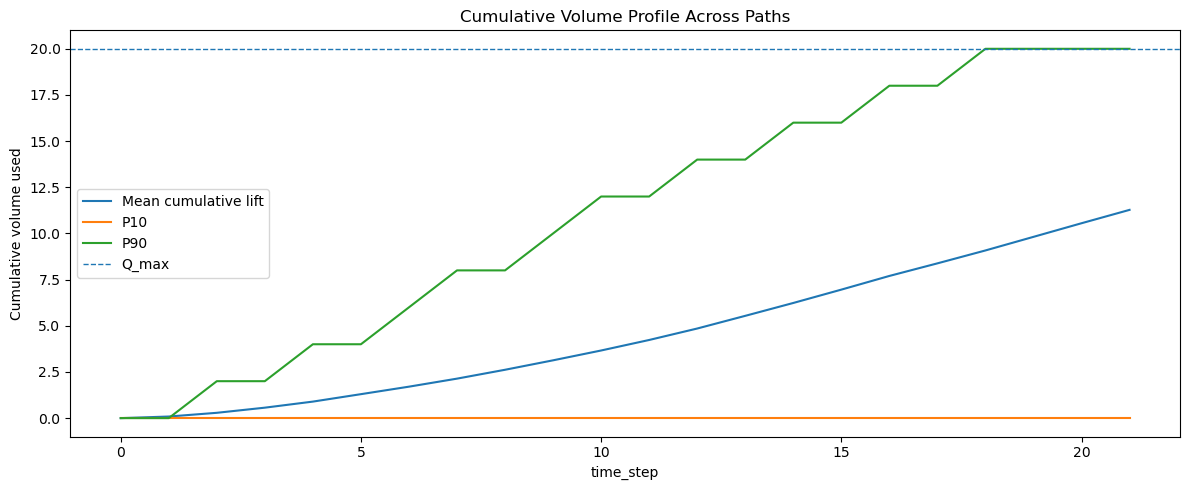

In [8]:
Q_max = 20.0

df = pd.read_csv(csv_filename)

path_col, time_col, qty_col = "path", "time_step", "q_t"

# Per-path cumulative lift
df = df.sort_values([path_col, time_col]).copy()
df["cum_q"] = df.groupby(path_col)[qty_col].cumsum()

# Cross-sectional summary at each time
agg = (df.groupby(time_col)["cum_q"]
         .agg(["mean",
               lambda x: np.percentile(x, 10),
               lambda x: np.percentile(x, 90)])
         .rename(columns={"<lambda_0>": "p10", "<lambda_1>": "p90"})
         .reset_index())

plt.figure(figsize=(12, 5))
plt.plot(agg[time_col], agg["mean"], label="Mean cumulative lift")
plt.plot(agg[time_col], agg["p10"], label="P10")
plt.plot(agg[time_col], agg["p90"], label="P90")
plt.xlabel("time_step")
plt.ylabel("Cumulative volume used")
plt.title("Cumulative Volume Profile Across Paths")
plt.axhline(Q_max, linestyle="--", linewidth=1, label="Q_max")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


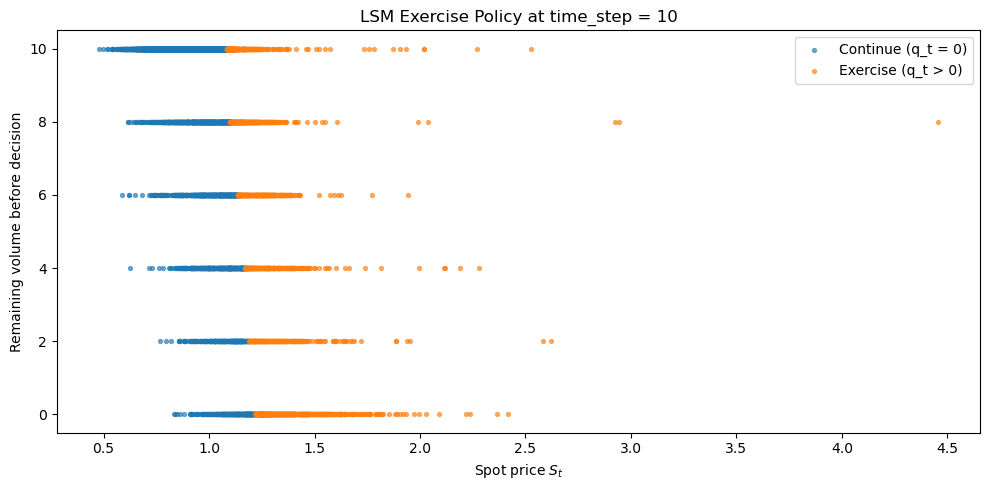

In [9]:
# Contract caps (for remaining-volume computation)
Q_max = SwingContract.Q_max
tol = 1e-9

df = pd.read_csv(csv_filename)

# Columns in this file
path_col, time_col, price_col, qty_col = "path", "time_step", "spot", "q_t"

# Sort and derive remaining volume BEFORE the action at each step
df = df.sort_values([path_col, time_col]).copy()
df["cum_q"] = df.groupby(path_col)[qty_col].cumsum()
df["cum_q_prev"] = df["cum_q"] - df[qty_col]
df["Q_remaining_before"] = np.maximum(Q_max - df["cum_q_prev"], 0.0)

# Middle time step snapshot
mid_step = int(df[time_col].max() // 2)
snap = df[df[time_col] == mid_step].copy()
snap["exercised"] = snap[qty_col] > tol

# Two small clouds: Continue vs Exercise
cont = snap[~snap["exercised"]]
exer = snap[snap["exercised"]]

plt.figure(figsize=(10, 5))
plt.scatter(cont[price_col], cont["Q_remaining_before"], s=8, alpha=0.6, label="Continue (q_t = 0)")
plt.scatter(exer[price_col], exer["Q_remaining_before"], s=8, alpha=0.6, label="Exercise (q_t > 0)")
plt.xlabel("Spot price $S_t$")
plt.ylabel("Remaining volume before decision")
plt.title(f"LSM Exercise Policy at time_step = {mid_step}")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


## Refraction (Cooldown) Periods

- Use `min_refraction_periods` to enforce a cooldown between exercises.
- Example: `min_refraction_periods = 1` blocks the immediate next decision period after any exercise.
- This constraint is implemented consistently in both the RL environment and the LSM benchmark.
- Previously this setting was named `min_refraction_days`; it has been renamed for clarity and now refers to decision periods (not calendar days).